In [ ]:
'''Attention-LSTM Time Series Forecasting (TensorFlow, Synthetic Data)'''

In [1]:
# Install necessary libraries
!pip install tensorflow yfinance scikit-learn

# Import libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Layer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.19.0


In [2]:
# Define the ticker symbol and data range
ticker_symbol = '^GSPC'
start_date = '2010-01-01'
end_date = '2023-12-31'

# Download the data
sp500_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Select the features we want to use
data = sp500_data[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

# Handle missing values (if any)
data = data.dropna()

# Display the first few rows and data info
print("Data Shape:", data.shape)
data.head()

/tmp/ipython-input-3241433779.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500_data = yf.download(ticker_symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Data Shape: (3522, 5)


Price,Open,High,Low,Close,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,5270680000
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,4389590000


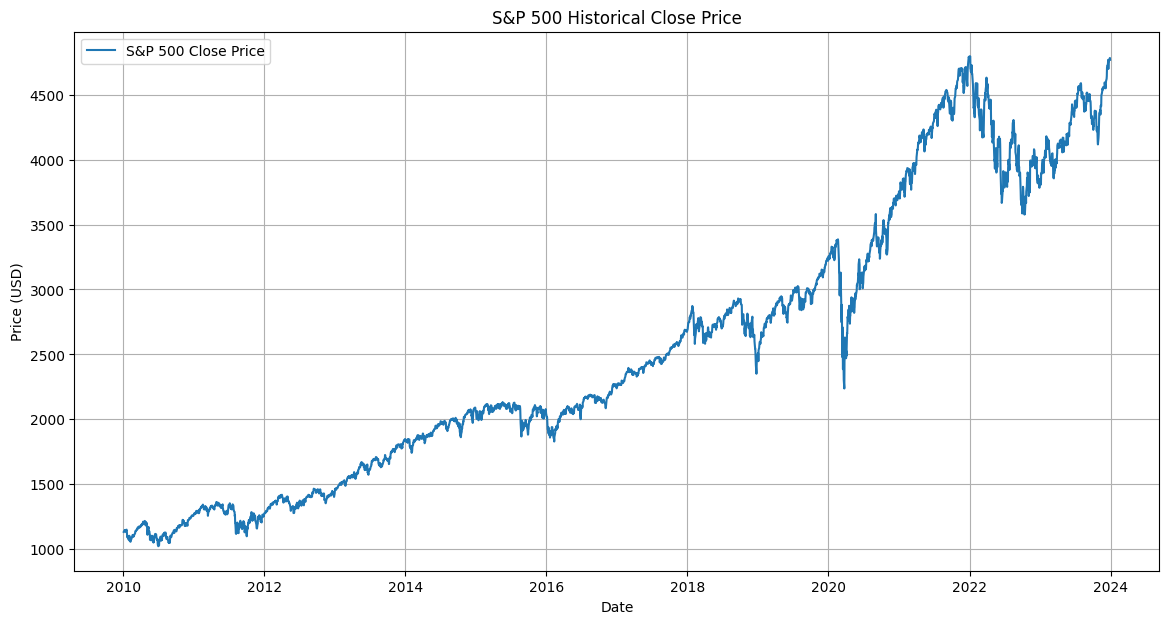

In [5]:
#Data Visualization
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='S&P 500 Close Price')
plt.title('S&P 500 Historical Close Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
'''Data Preprocessing
Scaling
Sequencing windowing
Train - Validatin - Test Split'''

# Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the data
scaled_data = scaler.fit_transform(data)

# Convert back to a DataFrame for easier handling
scaled_data = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)

def create_dataset(dataset, look_back=60):
    """
    Creates a dataset for time series forecasting.
    X: sequences of 'look_back' previous time steps.
    y: the 'Close' price at the next time step.
    """
    X, y = [], []
    close_price_index = data.columns.get_loc('Close') # Index of the 'Close' column

    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), :])
        y.append(dataset[i + look_back, close_price_index])

    return np.array(X), np.array(y)

# Define the number of previous time steps to use for prediction
look_back = 60 # Use 60 days of data to predict the next day

# Create the dataset
X, y = create_dataset(scaled_data.values, look_back)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

# Define the split ratios
train_ratio = 0.7
val_ratio = 0.15

# Calculate split indices
train_size = int(len(X) * train_ratio)
val_size = int(len(X) * val_ratio)

# Split the data
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

Shape of X: (3462, 60, 5)
Shape of y: (3462, 1)
Training set size: 2423
Validation set size: 519
Test set size: 520


In [10]:
'''Model Building
Baseline LSTM
(Custom Attention Layer)
Attention-LSTM'''
def build_baseline_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Build the baseline model
baseline_model = build_baseline_lstm_model((X_train.shape[1], X_train.shape[2]))
baseline_model.summary()

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight matrix for the attention mechanism
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # Compute attention scores
        attention_scores = tf.keras.backend.tanh(tf.keras.backend.dot(inputs, self.W))
        attention_weights = tf.keras.backend.softmax(attention_scores, axis=1)

        # Compute the context vector as a weighted sum of the LSTM outputs
        context_vector = attention_weights * inputs
        context_vector = tf.keras.backend.sum(context_vector, axis=1)

        return context_vector, attention_weights

    def compute_output_shape(self, input_shape):
        # Output shape is (batch_size, features) for context vector and (batch_size, time_steps, 1) for weights
        return [(input_shape[0], input_shape[2]), (input_shape[0], input_shape[1], 1)]

def build_attention_lstm_model(input_shape):
    inputs = Input(shape=input_shape)

    # LSTM layer
    lstm_out = LSTM(50, return_sequences=True)(inputs)
    lstm_out = Dropout(0.2)(lstm_out)

    # Attention layer
    context_vector, attention_weights = AttentionLayer()(lstm_out)

    # Output layer
    output = Dense(1)(context_vector)

    # Create the model
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

# Build the attention model
attention_model = build_attention_lstm_model((X_train.shape[1], X_train.shape[2]))
attention_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,701 (127.74 KB)

 Trainable params: 32,701 (127.74 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 60, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ [(None, 50), (None,    │            50 │
│ (AttentionLayer)                │ 60, 1)]                │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,301 (44.14 KB)

 Trainable params: 11,301 (44.14 KB)

 Non-trainable params: 0 (0.00 B)

Training Baseline LSTM Model...
Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 4.0459e-04 - val_loss: 0.0012
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 3.5673e-04 - val_loss: 0.0017
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 3.6994e-04 - val_loss: 6.5650e-04
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 3.8786e-04 - val_loss: 8.0625e-04
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 3.9363e-04 - val_loss: 9.2607e-04
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 2.9178e-04 - val_loss: 0.0016
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 3.5106e-04 - val_loss: 0.0016
Epoch 8/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 2.6376e-04 - val_loss: 5.8275e-04
Epoch 9/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 3.6263e-04 - val_loss: 0.0011
Epoch 10/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - loss: 3.0147e-04 - val_loss: 8.2810e-04
Epoch 11/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 75m

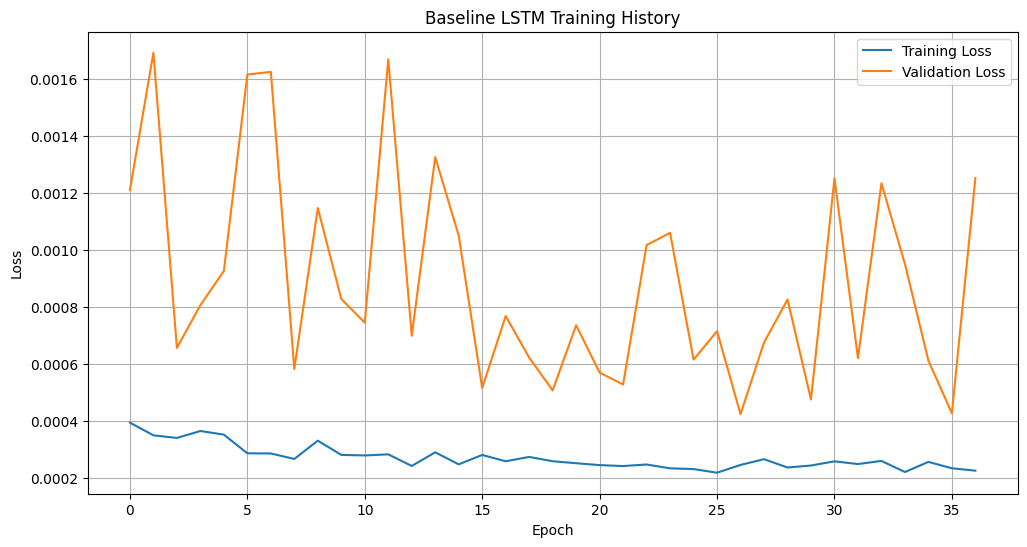

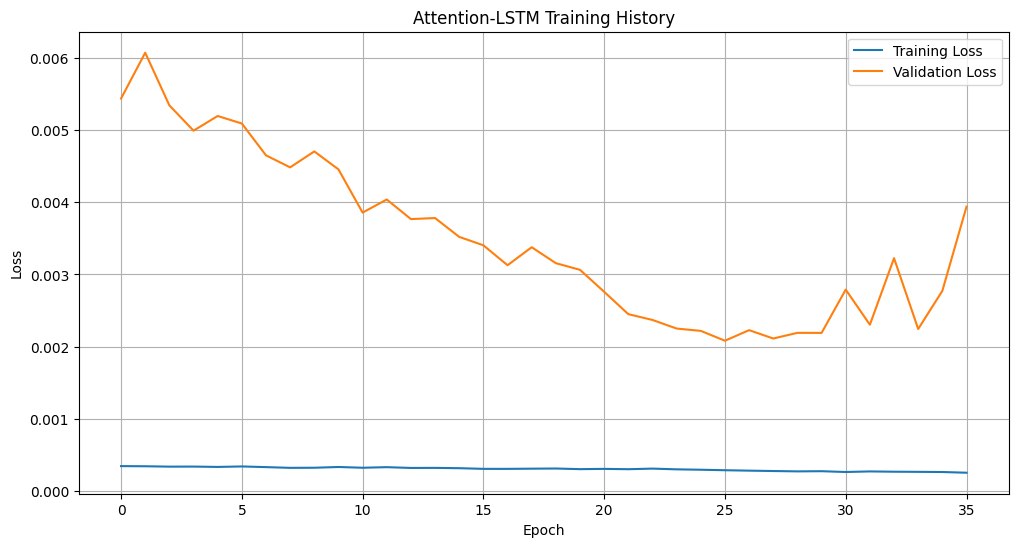

In [13]:
'''Model Training
Training History Visualization'''
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the baseline LSTM model
print("Training Baseline LSTM Model...")
baseline_history = baseline_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Train the Attention-LSTM model
print("\nTraining Attention-LSTM Model...")
attention_history = attention_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

def plot_history(history, title):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history(baseline_history, 'Baseline LSTM Training History')
plot_history(attention_history, 'Attention-LSTM Training History')

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Performance Comparison on Test Set:


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


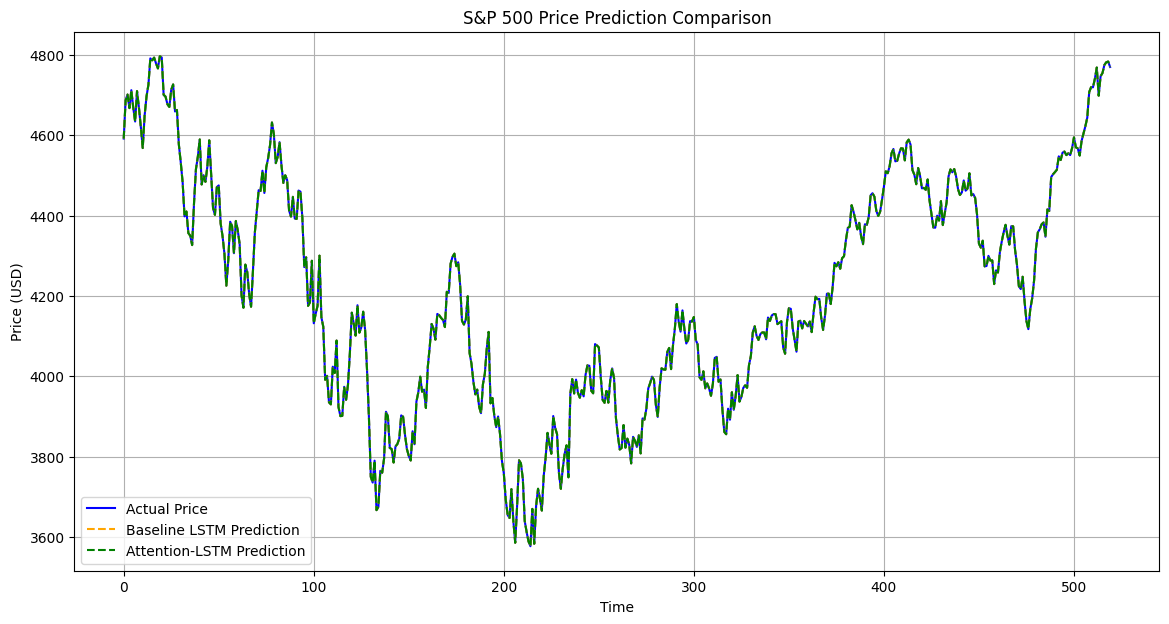

In [14]:
'''Evaluation and Comparison
   Prediction Visualization'''
# Make predictions
baseline_predictions = baseline_model.predict(X_test)
attention_predictions = attention_model.predict(X_test)

# Inverse transform the predictions and actual values to the original scale
# We need to create a dummy array with the same number of features as the original data
dummy_array = np.zeros((len(y_test), len(data.columns)))
dummy_array[:, data.columns.get_loc('Close')] = y_test

baseline_predictions_inv = scaler.inverse_transform(dummy_array)[:, data.columns.get_loc('Close')]
attention_predictions_inv = scaler.inverse_transform(dummy_array.copy())[:, data.columns.get_loc('Close')]
y_test_inv = scaler.inverse_transform(dummy_array)[:, data.columns.get_loc('Close')]

# Calculate metrics
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    # Directional Accuracy
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    directional_accuracy = np.mean(np.sign(y_true_diff) == np.sign(y_pred_diff)) * 100

    return rmse, mae, directional_accuracy

baseline_rmse, baseline_mae, baseline_da = calculate_metrics(y_test_inv, baseline_predictions_inv)
attention_rmse, attention_mae, attention_da = calculate_metrics(y_test_inv, attention_predictions_inv)

# Create a comparison table
metrics_data = {
    'Metric': ['RMSE', 'MAE', 'Directional Accuracy (%)'],
    'Baseline LSTM': [baseline_rmse, baseline_mae, baseline_da],
    'Attention-LSTM': [attention_rmse, attention_mae, attention_da]
}
metrics_df = pd.DataFrame(metrics_data)

print("Performance Comparison on Test Set:")
metrics_df

plt.figure(figsize=(14, 7))
plt.plot(y_test_inv, label='Actual Price', color='blue')
plt.plot(baseline_predictions_inv, label='Baseline LSTM Prediction', color='orange', linestyle='--')
plt.plot(attention_predictions_inv, label='Attention-LSTM Prediction', color='green', linestyle='--')
plt.title('S&P 500 Price Prediction Comparison')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


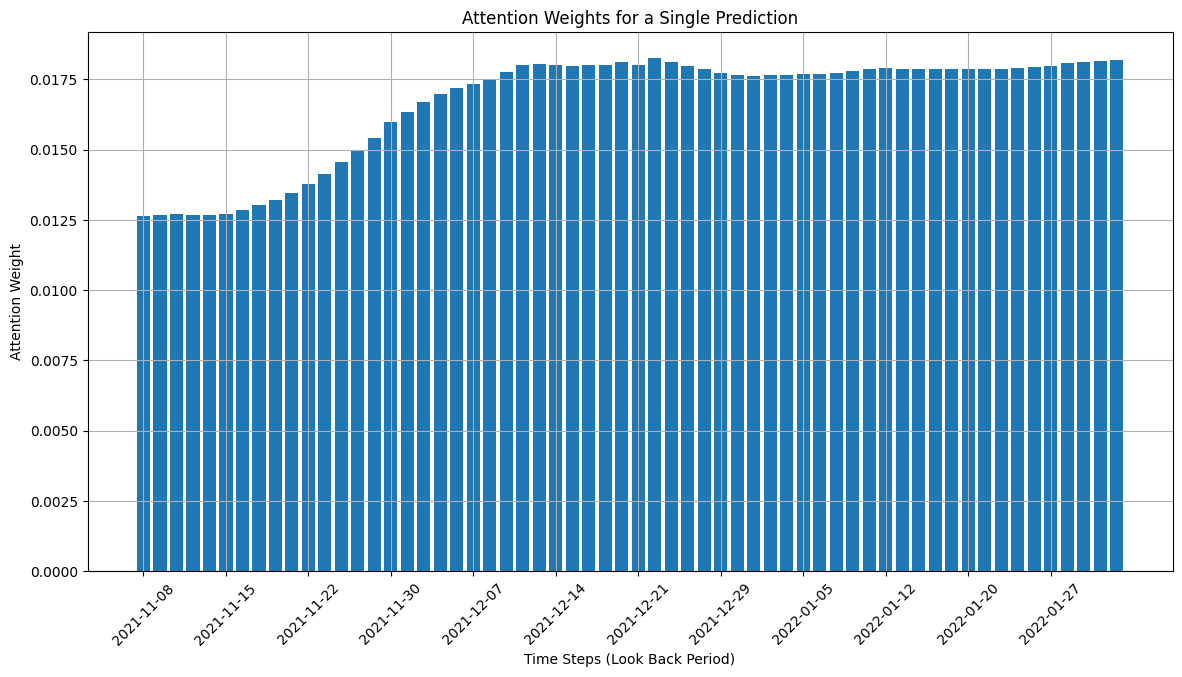

Predicted Next Day Close: 4131.93
Actual Next Day Close: 4131.93


In [16]:
'''Attention Weight Interpretation'''
# Create a new model to output the attention weights
attention_layer_model = Model(
    inputs=attention_model.input,
    outputs=[attention_model.output, attention_model.get_layer('attention_layer').output[1]]
)

# Get predictions and attention weights for a sample from the test set
sample_index = 100 # Choose a sample from the test set
sample_input = np.expand_dims(X_test[sample_index], axis=0)
prediction, attention_weights = attention_layer_model.predict(sample_input)

# Get the actual dates for the look_back period
look_back_dates = data.index[train_size + val_size + sample_index - look_back + 1 : train_size + val_size + sample_index + 1]

# Plot the attention weights
plt.figure(figsize=(14, 7))
plt.bar(range(look_back), attention_weights[0].flatten())
plt.title('Attention Weights for a Single Prediction')
plt.xlabel('Time Steps (Look Back Period)')
plt.ylabel('Attention Weight')
plt.xticks(range(0, look_back, 5), [date.strftime('%Y-%m-%d') for date in look_back_dates[::5]], rotation=45)
plt.grid(True)
plt.show()

# Extract scalar values before formatting
predicted_value = scaler.inverse_transform(dummy_array.copy())[sample_index, data.columns.get_loc('Close')]
actual_value = y_test_inv[sample_index]

print(f"Predicted Next Day Close: {predicted_value[0]:.2f}")
print(f"Actual Next Day Close: {actual_value[0]:.2f}")